In [109]:
import sys
%load_ext autoreload
%autoreload 2
import StepMiner as smn
import HegemonUtil as hu
import re
import numpy as np
import scipy
import math
import itertools
from itertools import combinations 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import statsmodels.stats.proportion
import seaborn as sns
import scanpy as sc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


https://github.com/theislab/scanpy/issues/85

In [31]:
def toScanpy(h):
    df1 = pd.read_csv(h.getExprFile(), sep="\t")
    adata = sc.AnnData(df1[df1.columns[2:]].T)
    adata.obs['arr'] = list(df1.columns[2:])
    adata.var['gene_ids'] = df1[df1.columns[0]]
    adata.var['gene_symbols'] = df1[df1.columns[1]]
    df = pd.read_csv(h.getSurv(), sep="\t")
    df.index = df.iloc[:,0]
    for k in df.columns:
        k1 = re.sub("^c ", "", k)
        k1 = re.sub("^n ", "", k1)
        val = [df[k][i] if i in df.index else '' for i in adata.obs['arr']]
        adata.obs[k1] = val
    return df1, adata

In [2]:
def toScanpy2(h):
    df1 = pd.read_csv(h.getExprFile(), sep="\t")
    print("Read expr file")
    adata = sc.AnnData(df1[df1.columns[2:]].T)
    print("adata transformed")
    adata.obs['arr'] = list(df1.columns[2:])
    print("arr")
    adata.var['gene_ids'] = [str(i) for i in df1[df1.columns[0]]]
    print("gene ids")
    adata.var['gene_symbols'] = [str(i) for i in df1[df1.columns[1]]]
    print("gene symbols")
    adata.var_names = list(adata.var['gene_symbols'])
    print("names")
    df = pd.read_csv(h.getSurv(), sep="\t")
    print("Read surv file")
    df.index = df.iloc[:,0]
    for k in df.columns:
        k1 = re.sub("^c ", "", k)
        k1 = re.sub("^n ", "", k1)
        val = [df[k][i] if i in df.index else '' for i in adata.obs['arr']]
        adata.obs[k1] = val
        print("read column")
    return df1, adata

### GSE130636

In [67]:
db = hu.Database("/booleanfs2/sahoo/Hegemon/explore.conf")
dbid = "RT42"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()
adata2 = toScanpy2(h)

In [95]:
adata = adata2[1]
adata

AnnData object with n_obs × n_vars = 8217 × 21649
    obs: 'arr', 'ArrayID', 'time', 'status', 'source', 'organism', 'donor', 'location', 'cluster label', 'cell type'
    var: 'gene_ids', 'gene_symbols'
    uns: 'cell type_colors'

In [102]:
adata.obs["cell type"]

c1               Unknown
c2          Glial Cell 3
c3                Cone 3
c4        Bipolar Cell 1
c5       Horizontal Cell
              ...       
c8213     Bipolar Cell 1
c8214     Bipolar Cell 2
c8215              Rod 2
c8216     Bipolar Cell 2
c8217     Bipolar Cell 2
Name: cell type, Length: 8217, dtype: category
Categories (18, object): [Amacrine Cell, Bipolar Cell 1, Bipolar Cell 2, Cone 3, ..., Retinal Ganglion Cell, Rod 1, Rod 2, Unknown]

In [120]:
adata3 = adata
cell_group = []

for i in adata3.obs["cell type"]:
    if i == 'Cone 3' or i == 'Cone 4':
        cell_group.append("Cone")
    elif i == 'Rod 1' or i == 'Rod 2':
        cell_group.append("Rod")
    elif i == "Bipolar Cell 1" or i == "Bipolar Cell 2":
        cell_group.append("BP")
    elif i == "Glial Cell 1" or i == "Glial Cell 2" or i == "Glial Cell 3" or i == "Glial Cell 4" or i == "Glial Cell 5":
        cell_group.append("Glial")
    elif i == 'Horizontal Cell':
        cell_group.append("HZ")
    elif i == 'Endothelial Cell':
        cell_group.append("ET")
    elif i == 'Pericyte':
        cell_group.append("Pericyte")
    elif i == 'Retinal Ganglion Cell':
        cell_group.append("Ganglion")
    elif i == 'Amacrine Cell':
        cell_group.append("Amacrine")
    else:
        cell_group.append(i)
        
adata3.obs["cell group"] = cell_group



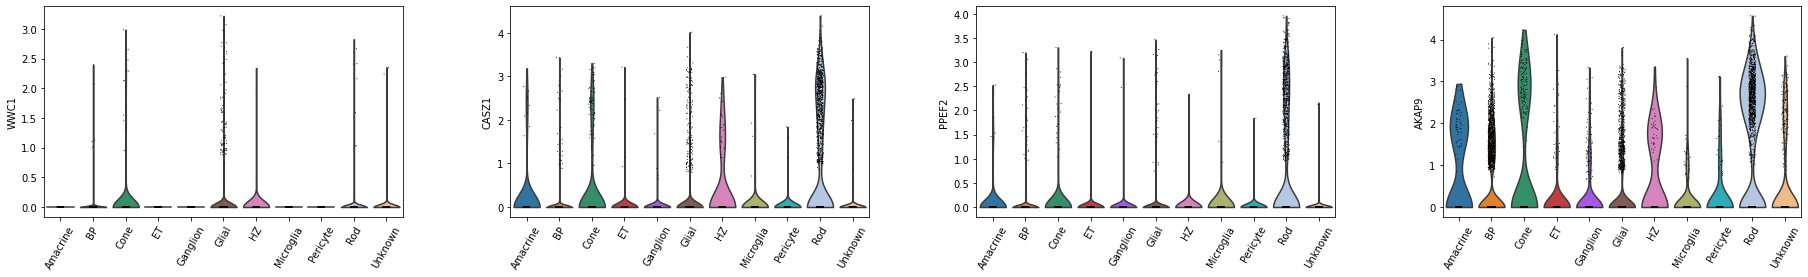

In [122]:
sc.pl.violin(adata3, ["WWC1","CASZ1","PPEF2","AKAP9"], groupby="cell group", rotation=60, save="voigt_SCplots.pdf")

### Lu 2020 Dataset 

In [ ]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT59"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

Loaded hegemon object
Converting to scanpy


In [ ]:
print("reading barcodes")
barcodes = pd.DataFrame(pd.read_csv('/Users/rohan/public_html/Hegemon/Data2/Data/GSE138002/GSE138002_Final_barcodes.csv', sep = ';', header=0))
print("finished")
print("reading genes")
genes = pd.DataFrame(pd.read_csv('/Users/rohan/public_html/Hegemon/Data2/Data/GSE138002/GSE138002_genes.csv', sep = ';',header=0))
genes.columns = ["ProbeID1","ProbeID","Name"]
genes = genes[["ProbeID","Name"]]
print("finished")
print("reading counts")
adata = (scipy.io.mmread('/Users/rohan/public_html/Hegemon/Data2/Data/GSE138002/GSE138002_Final_matrix.mtx'))
adata = adata.todense()
adata = pd.DataFrame(adata)
print("finished")

print("normalizing")
adata = sc.AnnData(adata.T)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
print("done normalizing")

adata.obs['arr'] = np.array(barcodes['barcode'])
adata.var['gene_ids']=np.array(genes["ProbeID"])
adata.var['names']=np.array(genes["Name"])
adata.var_names = adata.var["names"]
adata.obs_names = adata.obs["arr"]

df = pd.read_csv(h.getSurv(), sep="\t")
print("Read surv file")
df.index = df.iloc[:,0]
for k in df.columns:
    k1 = re.sub("^c ", "", k)
    k1 = re.sub("^n ", "", k1)
    val = [df[k][i] if i in df.index else '' for i in adata.obs['arr']]
    adata.obs[k1] = val
    print("read column")

celltype = list(adata.obs["cell type"])
for i in range(len(celltype)):
    if celltype[i] == "Amacrine Cells":
        celltype[i] = "AC"
print(np.unique(celltype))
adata.obs["celltype"] = celltype
adata

In [65]:
adata

AnnData object with n_obs × n_vars = 118555 × 33694
    obs: 'arr', 'ArrayID', 'time', 'status', 'source', 'organism', 'donor', 'location', 'cluster label', 'cell type', 'barcode', 'title', 'cell source', 'developmental stage', 'molecule', 'source_name', 'tissue', 'age', 'sample_region', 'celltype'
    var: 'gene_ids', 'names'
    uns: 'log1p', 'cell type_colors', 'celltype_colors', 'age_colors', 'source_name_colors'

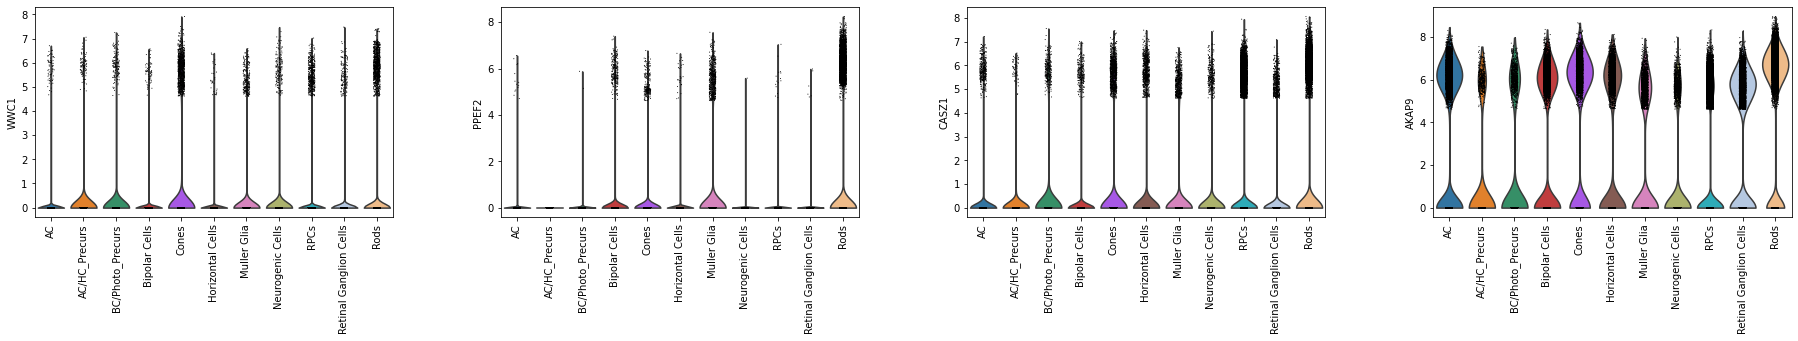

In [62]:
sc.pl.violin(adata, ["WWC1", "PPEF2", "CASZ1", "AKAP9"], groupby="celltype", rotation=90)

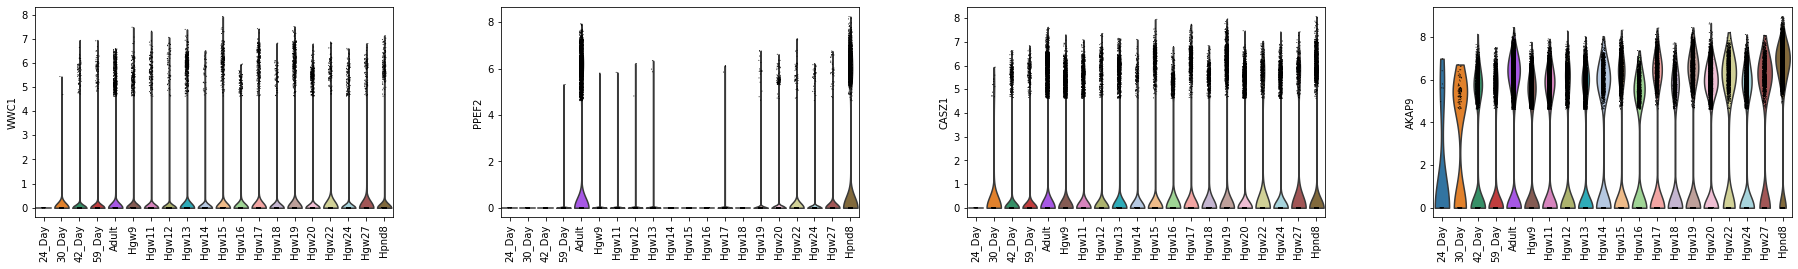

In [63]:
sc.pl.violin(adata, ["WWC1", "PPEF2", "CASZ1", "AKAP9"], groupby="age", rotation=90)

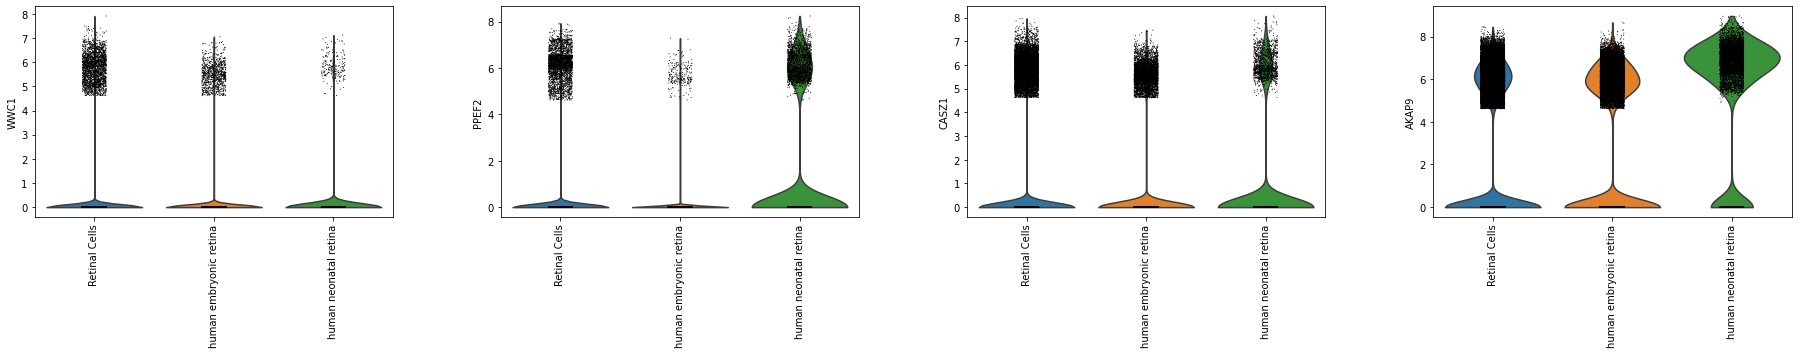

In [64]:
sc.pl.violin(adata, ["WWC1", "PPEF2", "CASZ1", "AKAP9"], groupby="source_name", rotation=90)

Retinal Cells


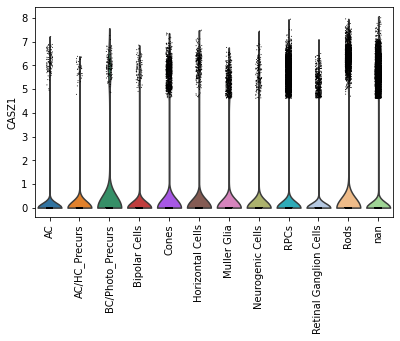

Human Embryonic Retina


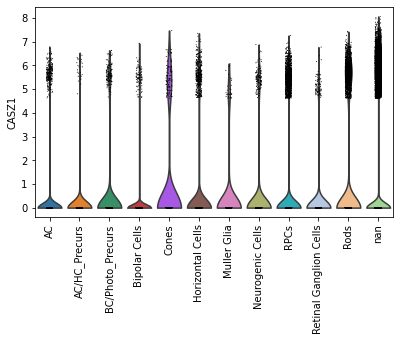

Human Neonatal Retina


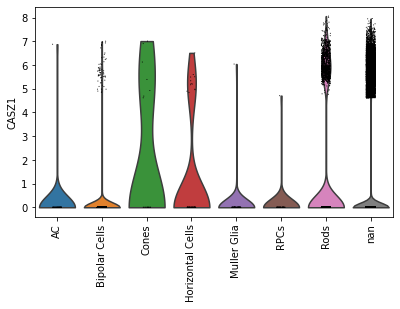

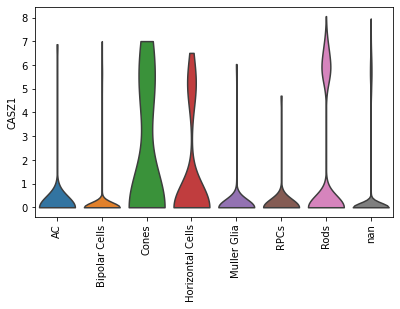

In [91]:
#Cell Source
print("Retinal Cells")
sc.pl.violin(adata, "CASZ1", groupby="celltype_RC", rotation=90)
print("Human Embryonic Retina")
sc.pl.violin(adata, "CASZ1", groupby="celltype_EC", rotation=90)
print("Human Neonatal Retina")
sc.pl.violin(adata, "CASZ1", groupby="celltype_NN", rotation=90)
sc.pl.violin(adata, "CASZ1", groupby="celltype_NN", rotation=90, stripplot=False)

Retinal Cells


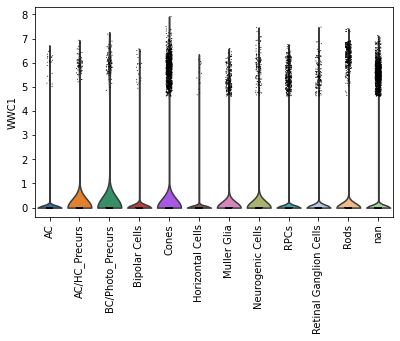

Human Embryonic Retina


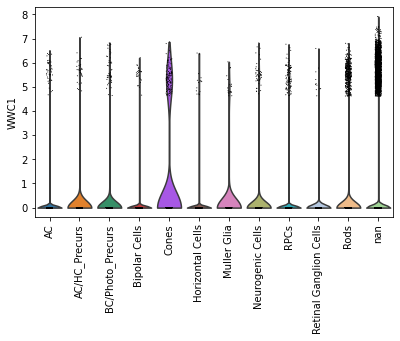

Human Neonatal Retina


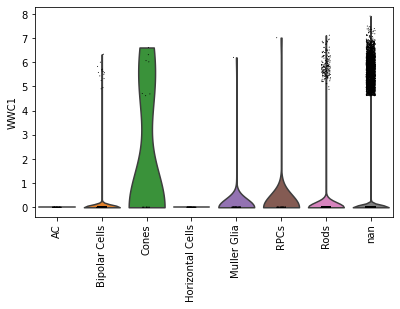

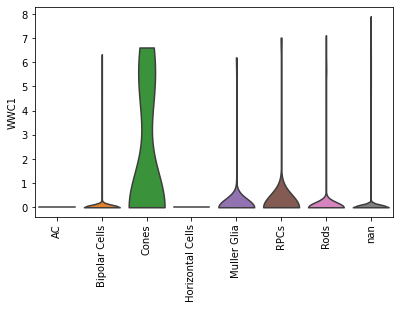

In [92]:
#Cell Source
print("Retinal Cells")
sc.pl.violin(adata, "WWC1", groupby="celltype_RC", rotation=90)
print("Human Embryonic Retina")
sc.pl.violin(adata, "WWC1", groupby="celltype_EC", rotation=90)
print("Human Neonatal Retina")
sc.pl.violin(adata, "WWC1", groupby="celltype_NN", rotation=90)
sc.pl.violin(adata, "WWC1", groupby="celltype_NN", rotation=90, stripplot=False)

Retinal Cells


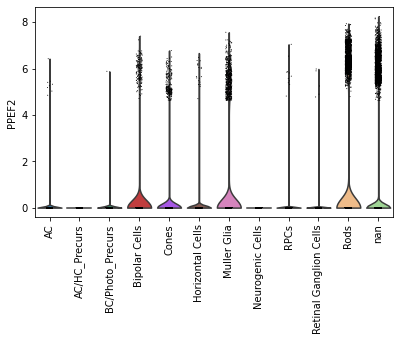

Human Embryonic Retina


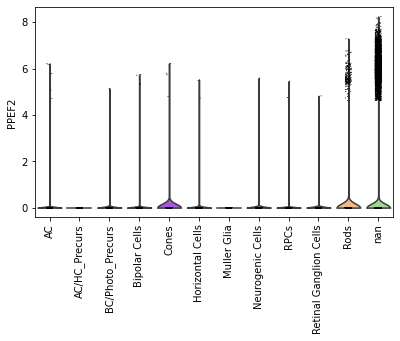

Human Neonatal Retina


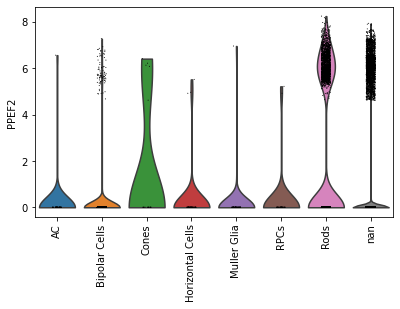

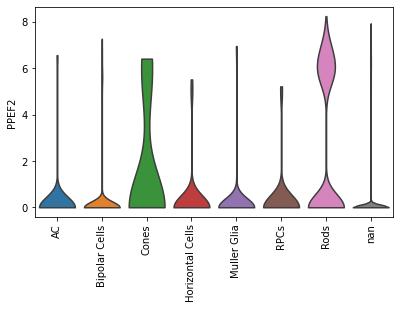

In [93]:
#Cell Source
print("Retinal Cells")
sc.pl.violin(adata, "PPEF2", groupby="celltype_RC", rotation=90)
print("Human Embryonic Retina")
sc.pl.violin(adata, "PPEF2", groupby="celltype_EC", rotation=90)
print("Human Neonatal Retina")
sc.pl.violin(adata, "PPEF2", groupby="celltype_NN", rotation=90)
sc.pl.violin(adata, "PPEF2", groupby="celltype_NN", rotation=90, stripplot=False)

In [5]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT59"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

In [10]:
celltype = h.getSurvName("c cell type")
source_name = h.getSurvName("c source_name")
rods = [i for i in h.aRange() if celltype[i] == 'Rods']
print(len(rods))
cones = [i for i in h.aRange() if celltype[i] == 'Cones']
print(len(cones))
horiz = [i for i in h.aRange() if celltype[i] == 'Horizontal Cells']
print(len(horiz))
rc = [i for i in h.aRange() if source_name[i] == "Retinal Cells"] #GSE138002
print(len(rc))
ec = [i for i in h.aRange() if source_name[i] == "human embryonic retina"] #GSE116106
print(len(ec))
nn = [i for i in h.aRange() if source_name[i] == "human neonatal retina"] #GSE122970
print(len(nn))

22677
6905
6882
71849
39324
7382


In [65]:
#CASZ1
def test(gene, cell_source):
    celltype = h.getSurvName("c cell type")
    source_name = h.getSurvName("c source_name")
    nn = [i for i in h.aRange() if source_name[i] == cell_source]
    e = h.getExprData(gene)
    e = [np.nan if e[i] == "" else float(e[i]) for i in h.aRange()]
    rods_nn = set(rods).intersection(nn)
    nn_norods = set(nn).difference(rods)
    e_rods_nn = [e[i] for i in range(len(e)) if i in rods_nn]
    e_norods_nn = [e[i] for i in range(len(e)) if i in nn_norods]
    cones_nn = set(cones).intersection(nn)
    e_cones_nn = [e[i] for i in range(len(e)) if i in cones_nn]
    prs_nn = set(rods+cones).intersection(nn)
    e_prs_nn = [e[i] for i in range(len(e)) if i in prs_nn]
    noprs_nn = set(nn).difference(rods+cones)
    e_noprs_nn = [e[i] for i in range(len(e)) if i in noprs_nn]
    print("average " + str(np.mean(e_rods_nn)) + " in " + str(len(e_rods_nn)) + " rods")
    print("average " + str(np.mean(e_cones_nn)) + " in " + str(len(e_cones_nn)) + " cones")
    print("average " + str(np.mean(e_prs_nn)) + " in " + str(len(e_prs_nn)) + " PRs")
    print("average " + str(np.mean(e_noprs_nn)) + " in " + str(len(e_noprs_nn)) + " retina excluding PRs")
    print("average " + str(np.mean(e_norods_nn)) + " in " + str(len(e_norods_nn)) + " retina excluding rods")
    print("T test between rods and cones")
    print(scipy.stats.ttest_ind(e_rods_nn, e_cones_nn, equal_var=False))
    print("T test between rods and rest of retina")
    print(scipy.stats.ttest_ind(e_rods_nn, e_norods_nn, equal_var=False))
    print("T test between PRs and rest of retina")
    print(scipy.stats.ttest_ind(e_prs_nn, e_noprs_nn, equal_var=False))

In [66]:
print("CASZ1")
print("Human embryonic retina (GSE116106)")
test("CASZ1", "human embryonic retina")
print("--")
print("Adult retinal cells (GSE138002)")
test("CASZ1", "Retinal Cells")
print("--")
print("Human neonatal retina (GSE122970)")
test("CASZ1", "human neonatal retina")

CASZ1
Human embryonic retina (GSE116106)
average 0.8345828616297355 in 6995 rods
average 0.7721446293103449 in 522 cones
average 0.8302469886390846 in 7517 PRs
average 0.6437945933222247 in 31807 retina excluding PRs
average 0.6458669963902378 in 32329 retina excluding rods
T test between rods and cones
Ttest_indResult(statistic=0.7020350583498185, pvalue=0.48292657626849445)
T test between rods and rest of retina
Ttest_indResult(statistic=7.235235625117493, pvalue=5.005931631856866e-13)
T test between PRs and rest of retina
Ttest_indResult(statistic=7.375722157282639, pvalue=1.757973186201244e-13)
--
Adult retinal cells (GSE138002)
average 0.9211185873410671 in 10775 rods
average 0.6298662347163287 in 6363 cones
average 0.8129823567569147 in 17138 PRs
average 0.6623999422474456 in 54711 retina excluding PRs
average 0.659010415099715 in 61074 retina excluding rods
T test between rods and cones
Ttest_indResult(statistic=9.329511729025961, pvalue=1.2081547049777184e-20)
T test between ro

In [67]:
print("PPEF2")
print("Human embryonic retina (GSE116106)")
test("PPEF2", "human embryonic retina")
print("--")
print("Adult retinal cells (GSE138002)")
test("PPEF2", "Retinal Cells")
print("--")
print("Human neonatal retina (GSE122970)")
test("PPEF2", "human neonatal retina")

PPEF2
Human embryonic retina (GSE116106)
average 0.07717726654753396 in 6995 rods
average 0.04304370766283525 in 522 cones
average 0.0748069435812159 in 7517 PRs
average 0.02633975410129846 in 31807 retina excluding PRs
average 0.02660946438491757 in 32329 retina excluding rods
T test between rods and cones
Ttest_indResult(statistic=1.4885687555548224, pvalue=0.13707041216426472)
T test between rods and rest of retina
Ttest_indResult(statistic=6.148414727287213, pvalue=8.198750837116239e-10)
T test between PRs and rest of retina
Ttest_indResult(statistic=6.182010434652585, pvalue=6.610705825666138e-10)
--
Adult retinal cells (GSE138002)
average 0.7857202008909513 in 10775 rods
average 0.16605510542197074 in 6363 cones
average 0.5556508227564476 in 17138 PRs
average 0.18827006225804688 in 54711 retina excluding PRs
average 0.18595559504862957 in 61074 retina excluding rods
T test between rods and cones
Ttest_indResult(statistic=26.367760261791226, pvalue=3.8594953928312e-150)
T test bet

In [81]:
#WWC1
def test(gene, cell_source):
    celltype = h.getSurvName("c cell type")
    source_name = h.getSurvName("c source_name")
    nn = [i for i in h.aRange() if source_name[i] == cell_source]
    e = h.getExprData(gene)
    e = [np.nan if e[i] == "" else float(e[i]) for i in h.aRange()]
    rods_nn = set(rods).intersection(nn)
    nn_norods = set(nn).difference(rods)
    e_rods_nn = [e[i] for i in range(len(e)) if i in rods_nn]
    e_norods_nn = [e[i] for i in range(len(e)) if i in nn_norods]
    cones_nn = set(cones).intersection(nn)
    nn_nocones = set(nn).difference(cones_nn)
    e_cones_nn = [e[i] for i in range(len(e)) if i in cones_nn]
    e_nocones_nn = [e[i] for i in range(len(e)) if i in nn_nocones]
    prs_nn = set(rods+cones).intersection(nn)
    e_prs_nn = [e[i] for i in range(len(e)) if i in prs_nn]
    noprs_nn = set(nn).difference(rods+cones)
    e_noprs_nn = [e[i] for i in range(len(e)) if i in noprs_nn]
    print("average " + str(np.mean(e_rods_nn)) + " in " + str(len(e_rods_nn)) + " rods")
    print("average " + str(np.mean(e_cones_nn)) + " in " + str(len(e_cones_nn)) + " cones")
    print("average " + str(np.mean(e_prs_nn)) + " in " + str(len(e_prs_nn)) + " PRs")
    print("average " + str(np.mean(e_noprs_nn)) + " in " + str(len(e_noprs_nn)) + " retina excluding PRs")
    print("average " + str(np.mean(e_nocones_nn)) + " in " + str(len(e_nocones_nn)) + " retina excluding cones")
    print("T test between cones and rods")
    print(scipy.stats.ttest_ind(e_cones_nn, e_rods_nn, equal_var=False))
    print("T test between cones and rest of retina")
    print(scipy.stats.ttest_ind(e_cones_nn, e_nocones_nn, equal_var=False))
    print("T test between PRs and rest of retina")
    print(scipy.stats.ttest_ind(e_prs_nn, e_noprs_nn, equal_var=False))
    t = h.getThrData(gene)[0]
    print("percentage of "+gene+"-high cells in cones")
    e_cones_high = [i for i in e_cones_nn if i>t]
    print(len(e_cones_high)/len(e_cones_nn))
    print("percentage of "+gene+"-high cells in rods")
    e_rods_high = [i for i in e_rods_nn if i>t]
    print(len(e_rods_high)/len(e_rods_nn))

WWC1

In [82]:
print("WWC1")
print("Human embryonic retina (GSE116106)")
test("WWC1", "human embryonic retina")
print("--")
print("Adult retinal cells (GSE138002)")
test("WWC1", "Retinal Cells")
print("--")
print("Human neonatal retina (GSE122970)")
test("WWC1", "human neonatal retina")

WWC1
Human embryonic retina (GSE116106)
average 0.18266767606862044 in 6995 rods
average 0.09512393793103448 in 522 cones
average 0.17658841156046295 in 7517 PRs
average 0.12206952900619361 in 31807 retina excluding PRs
average 0.13299381225710014 in 38802 retina excluding cones
T test between cones and rods
Ttest_indResult(statistic=-2.590329764582753, pvalue=0.009794823800151556)
T test between cones and rest of retina
Ttest_indResult(statistic=-1.1857940634061916, pvalue=0.2362247566871612)
T test between PRs and rest of retina
Ttest_indResult(statistic=4.489952343418671, pvalue=7.202859991646414e-06)
percentage of WWC1-high cells in cones
0.017241379310344827
percentage of WWC1-high cells in rods
0.033023588277340955
--
Adult retinal cells (GSE138002)
average 0.2742201751368909 in 10775 rods
average 0.1889687028760019 in 6363 cones
average 0.24256799180184385 in 17138 PRs
average 0.19064500241084972 in 54711 retina excluding PRs
average 0.20439637653849677 in 65486 retina excluding

Retinal Cells


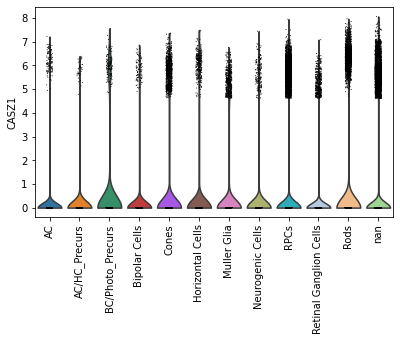

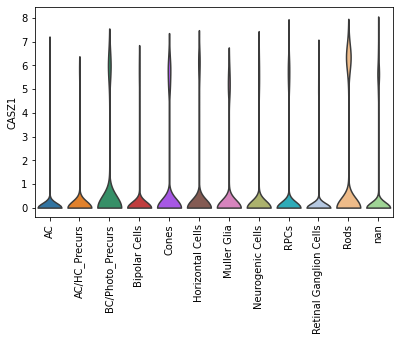

Human Embryonic Retina


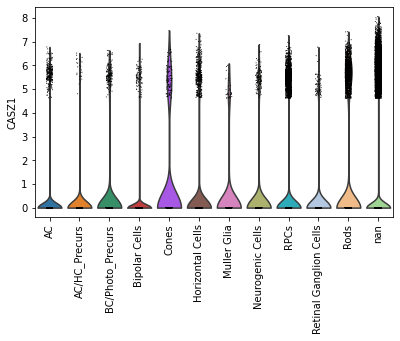

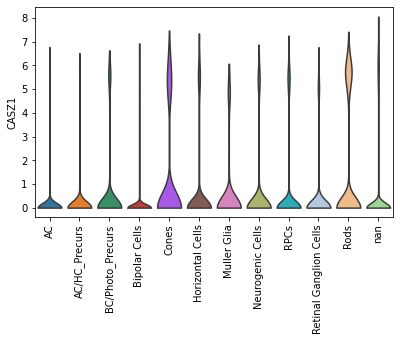

Human Neonatal Retina


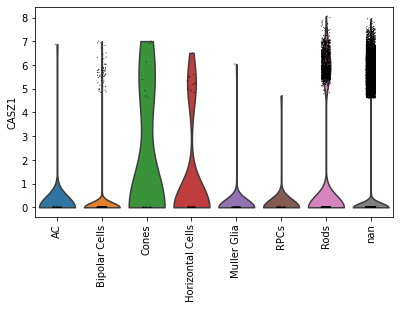

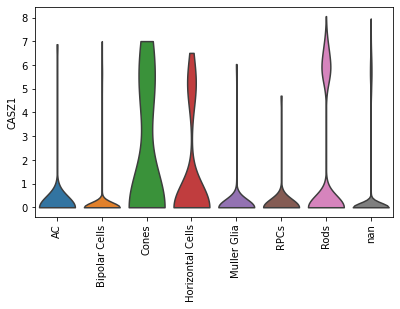

In [95]:
#Cell Source
print("Retinal Cells")
sc.pl.violin(adata, "CASZ1", groupby="celltype_RC", rotation=90)
sc.pl.violin(adata, "CASZ1", groupby="celltype_RC", rotation=90, stripplot=False)
print("Human Embryonic Retina")
sc.pl.violin(adata, "CASZ1", groupby="celltype_EC", rotation=90)
sc.pl.violin(adata, "CASZ1", groupby="celltype_EC", rotation=90, stripplot=False)
print("Human Neonatal Retina")
sc.pl.violin(adata, "CASZ1", groupby="celltype_NN", rotation=90)
sc.pl.violin(adata, "CASZ1", groupby="celltype_NN", rotation=90, stripplot=False)

### GSE148077 (Peng 2020 Dataset)

In [111]:
db = hu.Database("/Users/rohan/public_html/Hegemon/explore.conf")
dbid = "RT60"
h = hu.Hegemon(db.getDataset(dbid))
h.init()
h.initPlatform()
h.initSurv()

In [112]:
def types_dict(path, sep=',', header=0):
    df = pd.read_csv(path, nrows=3, sep=sep, header=header)
    for i in df.columns[1:]:
        df[i] = pd.to_numeric(df[i], downcast='unsigned')
    dtypes = df.dtypes
    colnames = dtypes.index
    types = [i.name for i in dtypes.values]
    column_types = dict(zip(colnames, types))
    return(column_types)

In [114]:
pathdir = "/Users/rohan/public_html/Hegemon/Data2/Data/GSE148077/rawData/"

i='GSE148077_count_mat_donor_H1.csv'
print("starting "+i)
typedict=types_dict(pathdir+i, sep=',', header=0)
print("dict")
expr = pd.DataFrame(pd.read_csv(pathdir+i, sep = ',', header=0, dtype=typedict))   
print("read")
print("finished "+i)


files = ['GSE148077_count_mat_donor_H2.csv','GSE148077_count_mat_donor_H3.csv',\
         'GSE148077_count_mat_donor_H4.csv', 'GSE148077_count_mat_donor_H5.csv', \
         'GSE148077_count_mat_donor_H9.csv','GSE148077_count_mat_donor_H11.csv']

for i in files:
    print("starting "+i)
    typedict=types_dict(pathdir+i, sep=',', header=0)
    print("dict")
    df = pd.DataFrame(pd.read_csv(pathdir+i, sep = ',', header=0, dtype=typedict))   
    print("read")
    expr = pd.merge(expr, df, on='Unnamed: 0', how="inner")
    print("merged")
    print("finished "+i)

genes = pd.DataFrame()
genes["ProbeID"] = expr['Unnamed: 0']
genes["Name"] = expr['Unnamed: 0']

count_mtx=expr.iloc[:,1:]
adata = sc.AnnData(count_mtx.T)
print("adata tranformed")
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)
print("normalized")

adata.obs['arr'] = np.array(count_mtx.columns[2:])
adata.var['gene_names'] = np.array(count_mtx["Name"])
adata.var_names = adata.var["gene_names"]
adata.obs_names = adata.obs["arr"]
df = pd.read_csv(h.getSurv(), sep="\t")
print("Read surv file")
df.index = df.iloc[:,0]
for k in df.columns:
    k1 = re.sub("^c ", "", k)
    k1 = re.sub("^n ", "", k1)
    val = [df[k][i] if i in df.index else '' for i in adata.obs['arr']]
    adata.obs[k1] = val
    print("read column "+k)
adata

celltype = h.getSurvName("c cell type")
cluster = h.getSurvName("c cluster")
source_name = h.getSurvName("c source_name")
rods = [i for i in h.aRange() if celltype[i] == 'Rods']
print(len(rods))
cones = [i for i in h.aRange() if celltype[i] == 'Cones']
print(len(cones))
mlCones = [i for i in h.aRange() if cluster[i] == 'mlCones']
print(len(mlCones))
sCones = [i for i in h.aRange() if cluster[i] == 'sCones']
print(len(sCones))
peri = [i for i in h.aRange() if source_name[i] == "Peripheral retina"] 
print(len(peri))
fovea = [i for i in h.aRange() if source_name[i] == "Fovea retina"]
print(len(fovea))

sc.set_figure_params(dpi_save=500)
sc.pl.violin(adata, 'WWC1', groupby="cell type", rotation=90, size=0.5, save="GSE148077_WWC1_plots.jpeg")
sc.pl.violin(adata, 'CASZ1', groupby="cell type", rotation=90, size=0.5, save="GSE148077_CASZ1_plots.jpeg")
sc.pl.violin(adata, 'PPEF2', groupby="cell type", rotation=90, size=0.5, save="GSE148077_PPEF2_plots.jpeg")

starting GSE148077_count_mat_donor_H1.csv
dict
read
finished GSE148077_count_mat_donor_H1.csv
starting GSE148077_count_mat_donor_H2.csv
dict
read
merged
finished GSE148077_count_mat_donor_H2.csv
starting GSE148077_count_mat_donor_H3.csv
dict
read
merged
finished GSE148077_count_mat_donor_H3.csv
starting GSE148077_count_mat_donor_H4.csv
dict
read
merged
finished GSE148077_count_mat_donor_H4.csv
starting GSE148077_count_mat_donor_H5.csv
dict
read
merged
finished GSE148077_count_mat_donor_H5.csv
starting GSE148077_count_mat_donor_H9.csv
dict
read
merged
finished GSE148077_count_mat_donor_H9.csv
starting GSE148077_count_mat_donor_H11.csv
dict
read
merged
finished GSE148077_count_mat_donor_H11.csv


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


adata tranformed
normalized


ValueError: Length of values does not match length of index

In [84]:
celltype = h.getSurvName("c cell type")
cluster = h.getSurvName("c cluster")
source_name = h.getSurvName("c source_name")
rods = [i for i in h.aRange() if celltype[i] == 'Rods']
print(len(rods))
cones = [i for i in h.aRange() if celltype[i] == 'Cones']
print(len(cones))
mlCones = [i for i in h.aRange() if cluster[i] == 'mlCones']
print(len(mlCones))
sCones = [i for i in h.aRange() if cluster[i] == 'sCones']
print(len(sCones))
peri = [i for i in h.aRange() if source_name[i] == "Peripheral retina"] 
print(len(peri))
fovea = [i for i in h.aRange() if source_name[i] == "Fovea retina"]
print(len(fovea))

7073
1997
1939
58
29322
56931


In [103]:
def test(gene, target, cell_source="all"):
    print(gene+" in "+cell_source)
    source_name = h.getSurvName("c source_name")
    if cell_source == "all":
        nn = h.aRange()
    else:
        nn = [i for i in h.aRange() if source_name[i] == cell_source]
    e = h.getExprData(gene)
    e = [np.nan if e[i] == "" else float(e[i]) for i in h.aRange()]
    if target == "Cones":
        rods_nn = set(rods).intersection(nn)
        nn_norods = set(nn).difference(rods)
        e_rods_nn = [e[i] for i in range(len(e)) if i in rods_nn]
        e_norods_nn = [e[i] for i in range(len(e)) if i in nn_norods]
        cones_nn = set(cones).intersection(nn)
        nn_nocones = set(nn).difference(cones_nn)
        e_cones_nn = [e[i] for i in range(len(e)) if i in cones_nn]
        e_nocones_nn = [e[i] for i in range(len(e)) if i in nn_nocones]
        prs_nn = set(rods+cones).intersection(nn)
        e_prs_nn = [e[i] for i in range(len(e)) if i in prs_nn]
        noprs_nn = set(nn).difference(rods+cones)
        e_noprs_nn = [e[i] for i in range(len(e)) if i in noprs_nn]
        print("average " + str(np.mean(e_rods_nn)) + " in " + str(len(e_rods_nn)) + " rods")
        print("average " + str(np.mean(e_cones_nn)) + " in " + str(len(e_cones_nn)) + " cones")
        print("average " + str(np.mean(e_prs_nn)) + " in " + str(len(e_prs_nn)) + " PRs")
        print("average " + str(np.mean(e_noprs_nn)) + " in " + str(len(e_noprs_nn)) + " retina excluding PRs")
        print("average " + str(np.mean(e_nocones_nn)) + " in " + str(len(e_nocones_nn)) + " retina excluding cones")
        print("T test between cones and rods")
        print(scipy.stats.ttest_ind(e_cones_nn, e_rods_nn, equal_var=False))
        print("T test between cones and rest of retina")
        print(scipy.stats.ttest_ind(e_cones_nn, e_nocones_nn, equal_var=False))
        print("T test between PRs and rest of retina")
        print(scipy.stats.ttest_ind(e_prs_nn, e_noprs_nn, equal_var=False))
        t = h.getThrData(gene)[0]
        print("percentage of "+gene+"-high cells in cones")
        e_cones_high = [i for i in e_cones_nn if i>t]
        print(len(e_cones_high)/len(e_cones_nn))
        print("percentage of "+gene+"-high cells in rods")
        e_rods_high = [i for i in e_rods_nn if i>t]
        print(len(e_rods_high)/len(e_rods_nn))
    if target == "Rods":
        rods_nn = set(rods).intersection(nn)
        nn_norods = set(nn).difference(rods)
        e_rods_nn = [e[i] for i in range(len(e)) if i in rods_nn]
        e_norods_nn = [e[i] for i in range(len(e)) if i in nn_norods]
        cones_nn = set(cones).intersection(nn)
        e_cones_nn = [e[i] for i in range(len(e)) if i in cones_nn]
        prs_nn = set(rods+cones).intersection(nn)
        e_prs_nn = [e[i] for i in range(len(e)) if i in prs_nn]
        noprs_nn = set(nn).difference(rods+cones)
        e_noprs_nn = [e[i] for i in range(len(e)) if i in noprs_nn]
        print("average " + str(np.mean(e_rods_nn)) + " in " + str(len(e_rods_nn)) + " rods")
        print("average " + str(np.mean(e_cones_nn)) + " in " + str(len(e_cones_nn)) + " cones")
        print("average " + str(np.mean(e_prs_nn)) + " in " + str(len(e_prs_nn)) + " PRs")
        print("average " + str(np.mean(e_noprs_nn)) + " in " + str(len(e_noprs_nn)) + " retina excluding PRs")
        print("average " + str(np.mean(e_norods_nn)) + " in " + str(len(e_norods_nn)) + " retina excluding rods")
        print("T test between rods and cones")
        print(scipy.stats.ttest_ind(e_rods_nn, e_cones_nn, equal_var=False))
        print("T test between rods and rest of retina")
        print(scipy.stats.ttest_ind(e_rods_nn, e_norods_nn, equal_var=False))
        print("T test between PRs and rest of retina")
        print(scipy.stats.ttest_ind(e_prs_nn, e_noprs_nn, equal_var=False))

In [108]:
adata

NameError: name 'adata' is not defined

In [105]:
test("WWC1", "Cones")
print("--")
test("CASZ1", "Rods")
print("--")
test("PPEF2", "Rods")

WWC1 in all
average 0.3566065607521561 in 7073 rods
average 0.48944073860791193 in 1997 cones
average 0.38585351259095924 in 9070 PRs
average 0.09231598607558855 in 77181 retina excluding PRs
average 0.11450279304840126 in 84254 retina excluding cones
T test between cones and rods
Ttest_indResult(statistic=3.298355945265577, pvalue=0.0009843911622710968)
T test between cones and rest of retina
Ttest_indResult(statistic=10.199502397728665, pvalue=7.477248126860967e-24)
T test between PRs and rest of retina
Ttest_indResult(statistic=18.945771646606513, pvalue=1.320143990915701e-78)
percentage of WWC1-high cells in cones
0.08262393590385578
percentage of WWC1-high cells in rods
0.06150148451859183
--
CASZ1 in all
average 1.6868178828078608 in 7073 rods
average 1.4247132714571857 in 1997 cones
average 1.6291086315545753 in 9070 PRs
average 0.19999862202096372 in 77181 retina excluding PRs
average 0.23088794929525877 in 79178 retina excluding rods
T test between rods and cones
Ttest_indResu